# **5 Things You Need to Know When Becoming an AirBnb Host in Seattle**

TK Description of this article's subject, focus and summary findings.  
TK Questions we will ask and answer.

As a future (or current) AirBnb host, your main goal is most probably maximizing revenue.  
Assuming the number of listings is fixed, this can happen in two ways:
1. get your listing(s) fully booked at all times.
2. set as high a price as possible without losing bookings.

Juggling between these two will help you determine the right ratio for you.

price and bookings have an inverse relationship

good reviews drive increased bookings
good reviews drive price increase

good service drives good reviews


impactful things a host can directly control:
- summary
- description
- host_response_time
- host_is_superhost
- bed_type
- ammenities
- price
- security_deposit
- cleaning_fee
- extra_people
- instant_bookable
- cancellation_policy

impactful things a host cannot directly control:
- location
- property_type
- room_type
- accommodates
- bathrooms
- bedrooms
- beds
- number_of_reviews
- ratings (all)

In [2]:
# std libraries
import os
import tarfile
import urllib
from zipfile import ZipFile

# data processing libraries
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Getting the Data

We'll be using the [AirBnb Seattle Open Data](https://www.kaggle.com/airbnb/seattle/data) from [kaggle](https://www.kaggle.com) to answer our questions.  
To do that, you we will need a kaggle account and an API key to download the data.  
A tutorial on how to setup your API key can be found on the [Kaggle Public API Documentation](https://www.kaggle.com/docs/api).  
Check it out and come back once it is done.

In [ ]:
# install kaggle package
!pip install kaggle

Now we just download the dataset using the API command.

In [ ]:
# you need a kaggle API key to run this command
!kaggle datasets download -d airbnb/seattle

And extract it in the local folder called 'data'.

In [3]:
dir_path = os.path.dirname(os.getcwd()) # get current working directory
zip_file_path = os.path.join(dir_path, './mediumblog/seattle.zip')
extract_dir_path = os.path.join(dir_path, './mediumblog/data/seattle/')

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_path)

First we'll take a look at the listings data.

In [3]:
seattle_listings = pd.read_csv('./data/seattle/listings.csv')
print("Columns: {}".format(seattle_listings.shape[1]))
print("Rows: {}".format(seattle_listings.shape[0]))
seattle_listings.sample(5)

Columns: 92
Rows: 3818


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2160,9733841,https://www.airbnb.com/rooms/9733841,20160104002432,2016-01-04,"Private, Cozy, Convenient W Seattle",Private bed and bath! Room features wonderful ...,This space was designed to give you maximum co...,Private bed and bath! Room features wonderful ...,none,Our neighborhood offers many amenities includi...,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
2199,4708075,https://www.airbnb.com/rooms/4708075,20160104002432,2016-01-04,Warm Urban Charmer,Welcome to our humble abode! Beautifully appo...,We offer warm hospitality that stems from our ...,Welcome to our humble abode! Beautifully appo...,none,The neighborhood has a lot to offer--to the ea...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,1.73
3563,1633025,https://www.airbnb.com/rooms/1633025,20160104002432,2016-01-04,Cozy nook on fantastic Cap Hill,NaN,"Enjoy the ideal location, with the quiet of th...","Enjoy the ideal location, with the quiet of th...",none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,2.36
3270,7650458,https://www.airbnb.com/rooms/7650458,20160104002432,2016-01-04,"Large, Beautiful, Affordable Condo",Condo is beautifully appointed & comfortable. ...,This is a top floor condo in a 16 unit building.,Condo is beautifully appointed & comfortable. ...,none,NaN,...,10.0,f,NaN,WASHINGTON,t,strict,f,f,1,0.36
636,4760472,https://www.airbnb.com/rooms/4760472,20160104002432,2016-01-04,"1BD Apt near Downtown, UW, Cap Hill",Enjoy all the comforts of home in our one bedr...,[UPDATE - there is construction happening on 2...,Enjoy all the comforts of home in our one bedr...,none,The apartment is in the heart of the Central D...,...,9.0,f,NaN,WASHINGTON,f,moderate,f,f,1,3.58


This dataset has quite a lot of columns, so we need to choose a subset that will be relevant to this analysis.  
I've created a curated list of columns removing anything that relates to technical elements (like 'scrape_id', 'thumbnail_url', etc.),  
irrelevant location columns (like 'street', 'city', 'state', etc.) and other elements that don't help (like 'neighborhood_overview' or 'experiences_offered').  
Here's what remains:

In [169]:
# relevant columns for the analysis
relevant_cols = ['id', 'name', 'description', 'host_since', 'host_response_time', 'host_acceptance_rate', 'host_is_superhost', \
                 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', \
                 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', \
                 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', \
                 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', \
                 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', \
                 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', \
                 'review_scores_value', 'cancellation_policy', 'reviews_per_month']

#### Type Conversion

Just by looking at the dataset info we see we have a few missing values here and there, and quite a few mistyped columns.  
Columns that should be dates:
 - 'host_since', 'first_review', 'last_review'  
 
Columns that should be numbers: 
 - as price: 'price', 'weekly_price', 'monthly_price', 'securing_deposit', 'cleaning_fee', 'extra_people'
 - as percentages: 'host_acceptance_rate'

In [170]:
# Converting date columns to date
date_cols = ['host_since', 'first_review', 'last_review']
for date_col in date_cols:
    seattle_listings[date_col] = pd.to_datetime(seattle_listings[date_col], errors='ignore') # because we have missing values

In [171]:
# Converting price columns to float
def clean_price(col):
    no_comma_price = col.str.replace(',', '')
    clean_price = no_comma_price.str.replace('$', '')
    return clean_price

price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

seattle_listings[price_cols] = seattle_listings[price_cols].apply(clean_price, axis=0) # remove commas and currency symbols from price strings
seattle_listings[price_cols] = seattle_listings[price_cols].astype(float) # convert price values to float

In [172]:
# Rename price columns to indicat _usd in name
new_price_cols = []
for price_col in price_cols:
    new_col_name = price_col + '_usd'
    new_price_cols.append(new_col_name)

rename_dict = dict()
for old_name, new_name in zip(price_cols, new_price_cols):
    rename_dict[old_name] = new_name

seattle_listings.rename(columns=rename_dict, inplace=True)

In [173]:
# Converting percentage columns to float
def clean_perc(col):
    no_perc_rate = col.str.replace('%', '')
    return no_perc_rate

rate_cols = ['host_acceptance_rate']

seattle_listings[rate_cols] = seattle_listings[rate_cols].apply(clean_perc, axis=0) # remove commas and currency symbols from price strings
seattle_listings[rate_cols] = seattle_listings[rate_cols].astype(float) / 100 # divide by 100 to get values bewtween 0 and 1

## 1. Does host response time predict review level?

In [84]:
response_time_counts = seattle_listings.groupby(['host_response_time']).size().sort_values(ascending=False)
response_time_counts['missing'] = seattle_listings['host_response_time'].isnull().sum()
print("Observations: {}".format(seattle_listings.shape[0]))
print((response_time_counts / seattle_listings.shape[0] * 100))

Observations: 3818
host_response_time
within an hour        44.316396
within a few hours    25.353588
within a day          15.636459
a few days or more     0.995285
missing               13.698271
dtype: float64


In [85]:
q1_df = seattle_listings.dropna(subset=['host_response_time'])

In [109]:
review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', \
               'review_scores_communication', 'review_scores_location', 'review_scores_value']

# multi column fillna not yet implemented
for col in review_cols:
    q1_df.loc[:, col] = q1_df[col].fillna(q1_df[col].median())

In [110]:
categ_order = [ "within an hour", \
                "within a few hours", \
                "within a day", \
                "a few days or more"]

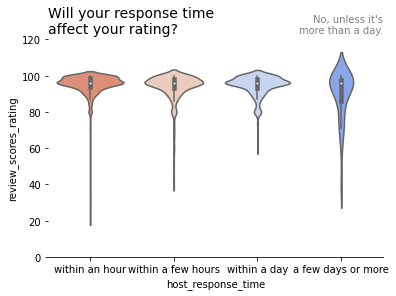

In [111]:
title = "Will your response time \naffect your rating?"
subtitle = "No, unless it's\nmore than a day."

sns.cubehelix_palette(as_cmap=True)
sns.violinplot(data=q1_df, x='host_response_time', y='review_scores_rating', palette="coolwarm_r",
               order=categ_order)

plt.title(title, loc='left', fontsize=14)
plt.title(subtitle, loc='right', fontsize=10, color='grey')
plt.ylim(0, 120)

sns.despine(left=True)

All distributions have an average above 80 points, but we see a bigger spread (lower kurtosis).  
This means that although all response times average above 80, there is a bigger chance to get a lower review if you answer within more than a day.  
I guess response speed does matter, especially if it's within a day.  
  
But let's see on which reviews categories it matters most.

In [112]:
categ_cols = ['host_response_time']

q1_cols = categ_cols + review_cols

resp_time_review_summary = seattle_listings[q1_cols].groupby(by=categ_cols).agg(np.mean)
resp_time_review_summary.loc[categ_order, :]

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
host_response_time,,,,,,,
within an hour,95.143984,9.685319,9.635766,9.817763,9.850099,9.653289,9.526316
within a few hours,93.812425,9.577431,9.508373,9.759904,9.760766,9.558223,9.379352
within a day,94.264831,9.630573,9.513800,9.726115,9.773305,9.588983,9.387712
a few days or more,87.793103,9.068966,8.551724,9.413793,9.206897,9.448276,8.862069


This table shows that **if you answer within at most a day, your ratings won't be impacted**.  

The cut-off appears when you answer within more than a day, where most lower reviews seem to be.    
Let's see if and where this cut-off difference is more significant.  

In [114]:
response_mappings = {
    "within an hour": "a day or less",
    "within a few hours": "a day or less",
    "within a day": "a day or less",
    "a few days or more": "more than a day"
}

response_bin_col = 'host_response_time_bins'
q1_df.loc[:, response_bin_col] = q1_df['host_response_time'].map(response_mappings)

In [115]:
q1_response_bin_cols = [response_bin_col] + review_cols

In [142]:
from scipy.stats import ttest_ind

day_less_mask = q1_df[response_bin_col] == 'a day or less'
more_days_mask = q1_df[response_bin_col] == 'more than a day'
day_less_df = q1_df.loc[day_less_mask, review_cols]
more_days_df = q1_df.loc[more_days_mask, review_cols]

q1_cols = categ_cols + review_cols
tset, pvals = ttest_ind(day_less_df, more_days_df, equal_var=False)

In [143]:
mean_diffs = day_less_df.mean() - more_days_df.mean()
diff_cols = list(mean_diffs.index)
diff_means = list(mean_diffs.values)

In [146]:
for col, mean_diff, pval in zip(diff_cols, diff_means, pvals):
    print("{}: \t {:.2f} ({:.2%})".format(col, mean_diff, pval))

review_scores_rating: 	 5.05 (2.63%)
review_scores_accuracy: 	 0.40 (4.72%)
review_scores_cleanliness: 	 0.74 (0.45%)
review_scores_checkin: 	 0.26 (6.97%)
review_scores_communication: 	 0.44 (6.09%)
review_scores_location: 	 0.09 (44.09%)
review_scores_value: 	 0.40 (6.58%)


Your response time does in fact affect your overall rating, with about 5 points out of 100 on average*.  
*assuming we set the significance threshold at 5%.

Here are the top 3 rating categories that negatively impact your scores:
- cleanliness (0.7 points out of 10)
- accuracy (0.4 points out of 10)  

Cleanliness is odd, as there is no intuitive connection between it and host response time (although they do both signal lack of attention or interest to the whole hosting activity).

With close seconds (>7% significance threshold):
- communication (0.4 points out of 10)
- checkin (0.3 points out of 10)
- value (0.4 points out of 10)

And very low significance in location score, which is expected, but a great sanity check nontheless.

#### Conclusion:
Q: Does your response time affect your ratings?  
A: Yes. If you answer in more than a day, you may get a 5 point lower overall rating (out of 100).  
This lower review will most likely come from accuracy, communication, checkin, or it may stem from lack of attention to your listings which will also affect value and cleanliness.

## 2. Does superhost status increase bookings for the listing?

To answer this, we need the calendar of bookings for each listing.  
This data contains a list of days between 2016-01-04 and 2017-01-02 of dates and respective booking for each listing (f - if booked, t - if available).

In [279]:
seattle_clndr = pd.read_csv('./data/seattle/calendar.csv')
print("Columns: {}".format(seattle_clndr.shape[1]))
print("Rows: {}".format(seattle_clndr.shape[0]))
seattle_clndr.sample(5)

Columns: 4
Rows: 1393570


,listing_id,date,available,price
1041237,3766285,2016-09-17,f,NaN
1086952,8033438,2016-12-16,t,$49.00
616052,6228959,2016-10-27,t,$128.00
672676,7788695,2016-12-15,f,NaN
324918,7581974,2016-03-12,f,NaN


In [305]:
seattle_booked = seattle_clndr[seattle_clndr['available'] == 'f']
booking_counts = seattle_booked.groupby(by=['listing_id']).size().reset_index()
listings_booked = booking_counts.rename({0: 'nights_booked'}, axis=1)
listings_booked.set_index('listing_id', inplace=True)
listings_booked.sample(3)

,nights_booked
listing_id,
6823837,38
6973790,29
1594219,98


In [306]:
q3_df = pd.merge(seattle_listings, listings_booked, how='left', left_on='id', right_on='listing_id')
q3_clean_df = q3_df.dropna(subset=['nights_booked'])

In [330]:
superhost_mask = q3_clean_df['host_is_superhost'] == 't'

superhost_df = q3_clean_df.loc[superhost_mask, ['nights_booked']]
non_superhost_df = q3_clean_df.loc[~superhost_mask, ['nights_booked']]

tset, pvals = ttest_ind(superhost_df, non_superhost_df, equal_var=False)

mean_diff = superhost_df.mean() - non_superhost_df.mean()
mean_diff = mean_diff.values[0]

print("Bookings Diff \t Sign")
print("{:.2f} \t\t ({:.2%})".format(mean_diff, pvals[0]))

Bookings Diff 	 Sign
-8.65 		 (9.90%)


It seems that having a superhost status acutally REDUCES the number of bookings you get in a year by around 8/9 days. It's not extremely statistically significant, so we shouldn't be too sure on this result.  

Let's also check if the superhost status at least allows a price increase to compensate for fewer bookings:

In [331]:
superhost_mask = q3_clean_df['host_is_superhost'] == 't'

superhost_df = q3_clean_df.loc[superhost_mask, ['price_usd']]
non_superhost_df = q3_clean_df.loc[~superhost_mask, ['price_usd']]

tset, pvals = ttest_ind(superhost_df, non_superhost_df, equal_var=False)

mean_diff = superhost_df.mean() - non_superhost_df.mean()
mean_diff = mean_diff.values[0]

print("Price Diff \t Sign")
print("{:.2f} \t\t ({:.2%})".format(mean_diff, pvals[0]))

Price Diff 	 Sign
2.81 		 (46.79%)


#### Conclusion:
Q: Does superhost status increase bookings for the listing?  
A: No, data shows that having superhost status might actually reduce the number of bookings you get. Also, there is no significant price increase (none at all) with a superhost status, so you shouldn't worry about it.

## 3. How much does the cleaning fee influence bookings?

In [333]:
# create flag columns for features with meaning behind missing data
flag_cols = ['security_deposit_usd', 'cleaning_fee_usd', 'host_response_time']

for col in flag_cols:
    col_flag = col + '_missing_flag'
    seattle_listings[col_flag] = 1 - seattle_listings[col].isnull() * 1 # creates 1's for missing values and 0's for all other

In [334]:
seattle_clndr = pd.read_csv('./data/seattle/calendar.csv')
print("Columns: {}".format(seattle_clndr.shape[1]))
print("Rows: {}".format(seattle_clndr.shape[0]))

seattle_booked = seattle_clndr[seattle_clndr['available'] == 'f']
booking_counts = seattle_booked.groupby(by=['listing_id']).size().reset_index()
listings_booked = booking_counts.rename({0: 'nights_booked'}, axis=1)
listings_booked.set_index('listing_id', inplace=True)
listings_booked.sample(3)

Columns: 4
Rows: 1393570


,nights_booked
listing_id,
8066883,279
3759039,365
6481695,1


In [336]:
q4_df = pd.merge(seattle_listings, listings_booked, how='left', left_on='id', right_on='listing_id')
q4_clean_df = q4_df.dropna(subset=['nights_booked'])

In [341]:
cleanfee_mask = q4_clean_df['cleaning_fee_usd_missing_flag'] == 1

cleanfee_df = q4_clean_df.loc[cleanfee_mask, ['nights_booked']]
nocleanfee_df = q4_clean_df.loc[~cleanfee_mask, ['nights_booked']]

tset, pvals = ttest_ind(nocleanfee_df, cleanfee_df, equal_var=False)

mean_diff = nocleanfee_df.mean() - cleanfee_df.mean()
mean_diff = mean_diff.values[0]

print("Bookings Diff \t Sign")
print("{:.2f} \t\t ({:.2%})".format(mean_diff, pvals[0]))

Bookings Diff 	 Sign
17.16 		 (0.11%)


In [345]:
cleanfee_mask = q4_clean_df['cleaning_fee_usd_missing_flag'] == 1

cleanfee_df = q4_clean_df.loc[cleanfee_mask, ['price_usd']]
nocleanfee_df = q4_clean_df.loc[~cleanfee_mask, ['price_usd']]

tset, pvals = ttest_ind(nocleanfee_df, cleanfee_df, equal_var=False)

mean_diff = nocleanfee_df.mean() - cleanfee_df.mean()
mean_diff = mean_diff.values[0]

print("Price Diff (USD) \t Sign")
print("{:.2f} \t\t\t ({:.2%})".format(mean_diff, pvals[0]))

Price Diff (USD) 	 Sign
-34.90 			 (0.00%)


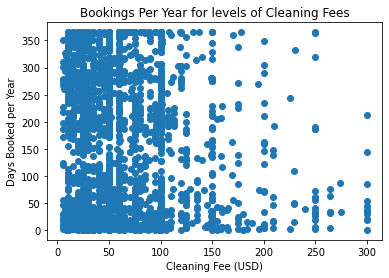

In [351]:
plt.scatter(q4_clean_df['cleaning_fee_usd'], q4_clean_df['nights_booked'])
plt.title('Bookings Per Year for levels of Cleaning Fees')
plt.xlabel('Cleaning Fee (USD)')
plt.ylabel('Days Booked per Year')

plt.show()

In [362]:
def group_fees(row):
    cfee = row['cleaning_fee_usd']
    if cfee < 50:
        return '<50'
    elif cfee < 100:
        return '[50-100)'
    elif cfee < 150:
        return '[100-150)'
    elif cfee < 200:
        return '[150-200)'
    elif cfee < 250:
        return '[200-250)'
    elif cfee >= 250:
        return '>250'
    else:
        return 'no fee'
    
q4_clean_df.loc[:,'cleaning_fee_tiers'] = q4_clean_df[['cleaning_fee_usd']].apply(group_fees, axis=1)
fee_booking_summary = q4_clean_df[['cleaning_fee_tiers', 'nights_booked']].groupby(by=['cleaning_fee_tiers']).agg(np.mean)

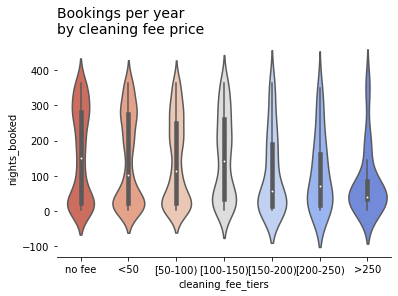

In [375]:
row_order = ['no fee', '<50', '[50-100)', '[100-150)', '[150-200)', '[200-250)', '>250']

title = "Bookings per year\nby cleaning fee price"
subtitle = ""

sns.cubehelix_palette(as_cmap=True)
sns.violinplot(data=q4_clean_df, x='cleaning_fee_tiers', y='nights_booked', palette="coolwarm_r",
               order=row_order)

plt.title(title, loc='left', fontsize=14)
plt.title(subtitle, loc='right', fontsize=10, color='grey')

sns.despine(left=True)

#### Conclusion:
Q: How much does the cleaning fee influence bookings?   
A: Very much! Listings without cleaning fee get on average 17 more booked days per year than listings with cleaning fees. And the previous graph shows the number of days booked declines as cleaning fee gets higher.

## 4. Are there any high traffic seasons you should prepare for?

In [142]:
seattle_clndr = pd.read_csv('./data/seattle/calendar.csv')
print("Columns: {}".format(seattle_clndr.shape[1]))
print("Rows: {}".format(seattle_clndr.shape[0]))
seattle_clndr.sample(5)

Columns: 4
Rows: 1393570


,listing_id,date,available,price
321852,4773614,2016-10-17,t,$100.00
1329072,1920477,2016-04-20,t,$75.00
440242,1696015,2016-02-25,f,NaN
780812,8596938,2016-03-21,f,NaN
387605,7241905,2016-12-09,t,$115.00


In [144]:
# convert date column to datetime
seattle_clndr['date'] = pd.to_datetime(seattle_clndr['date'])

# get date attributes of interest: year and month
seattle_clndr['year'] = seattle_clndr['date'].dt.year
seattle_clndr['month'] = seattle_clndr['date'].dt.month

# create year_month column
seattle_clndr['year_month'] = seattle_clndr['year'].astype(str) + '-' +\
                             seattle_clndr['month'].astype(str).str.pad(2, side='left', fillchar='0')

# keep only 2016 - 2017 data seems incomplete
before_2017_mask = seattle_clndr['date'] < '2017-01-01'
seattle_clndr_b2007 = seattle_clndr[before_2017_mask]

In [145]:
# keep only booked days
booking_mask = seattle_clndr_b2007['available'] == 'f'
bookings_df = seattle_clndr_b2007[booking_mask]

# group by year and month and reset index
bookings_per_month = bookings_df.groupby(['year_month']).size()
bookings_per_month = bookings_per_month.reset_index().rename({0:'bookings'}, axis=1)

In [147]:
# keep only available listing observations
no_bookings_df = seattle_clndr_b2007[~booking_mask]

# Converting price columns to float
def clean_price(col):
    no_comma_price = col.str.replace(',', '')
    clean_price = no_comma_price.str.replace('$', '')
    return clean_price

price_cols = ['price']

no_bookings_df[price_cols] = no_bookings_df[price_cols].apply(clean_price, axis=0) # remove commas and currency symbols from price strings
no_bookings_df[price_cols] = no_bookings_df[price_cols].astype(float) # convert price values to float

# group by year and month and reset index
nobook_per_month = no_bookings_df[['year_month', 'price']].groupby(['year_month']).agg(np.mean)
nobook_per_month = nobook_per_month.reset_index()

C:\Users\gradi\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


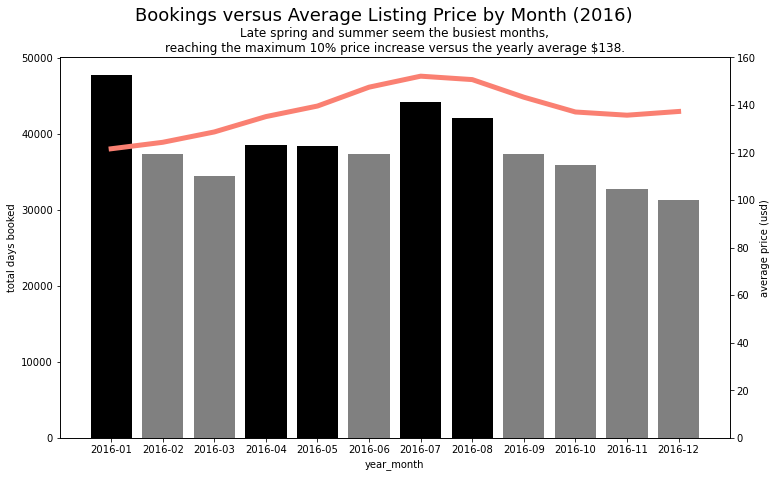

In [167]:
# calculate mean and create color mask based on if the value is higher (red) or lower (grey)
threshold = bookings_per_month['bookings'].mean()
clrs = ['grey' if (x <= threshold) else 'black' for x in bookings_per_month['bookings']]

# plot line
fig, ax1 = plt.subplots(figsize = (12,7))

plot1 = sns.barplot(data=bookings_per_month, x="year_month", y="bookings", palette=clrs, ax=ax1)
ax1.set_ylabel('total days booked')

ax2 = ax1.twinx()
plot2 = sns.lineplot(data=nobook_per_month, x="year_month", y="price", color="salmon", linewidth=5, ax=ax2)
ax2.set_ylabel('average price (usd)')
ax2.set_ylim((0,160))
                   
# plot details
plt.suptitle('Bookings versus Average Listing Price by Month (2016)', fontsize=18)
plt.title('Late spring and summer seem the busiest months,\nreaching the maximum 10% price increase versus the yearly average $138.', fontsize=12)

plt.xlabel('month')

plt.show()

#### Conclusion:
Q: Are there any high traffic seasons you should prepare for?  
A: Yes, late spring and summer have higher number of days booked versus the rest of the year, with a price increase up to 10% during the same period.  
Interestingly, we see a very high number of bookings during January 2016, when the price is the lowest all year. I wonder what would explain this dynamic, or if it's just a 2016 anomaly. We would need more data to confirm this entire trend.  
Conclusion: Prepare for the increased traffic late spring and summer and be sure to increase your price up to 10%.

## 5. How much does location impact your listing value?

In [174]:
q5_df = seattle_listings.loc[:,:]
q5_df['price_usd'].isnull().sum()

0

Price has no missing values, so we can go ahead and plot the values

In [175]:
def plot_feature_on_map(df=q5_df, feature='price_usd', size=8):
    BBox = (df.longitude.min(), df.longitude.max(),      
            df.latitude.min(), df.latitude.max())

    seattle_m = plt.imread('./images/seattle.png')

    fig, ax = plt.subplots(figsize = (8,7))
    fig.patch.set_facecolor('white')
    scatter = ax.scatter(df['longitude'], df['latitude'], \
               cmap=plt.get_cmap('icefire'), c=df[feature], \
               zorder=1, s=size)

    plt.colorbar(scatter)

    ax.set_xlim(BBox[0],BBox[1])
    ax.set_xticks([])

    ax.set_ylim(BBox[2],BBox[3])
    ax.set_yticks([])

    ax.set_title('Listings by {} in Seattle Area'.format(feature))
    
    ax.imshow(seattle_m, zorder=0, extent = BBox, aspect= 'equal')
    
    plt.show()

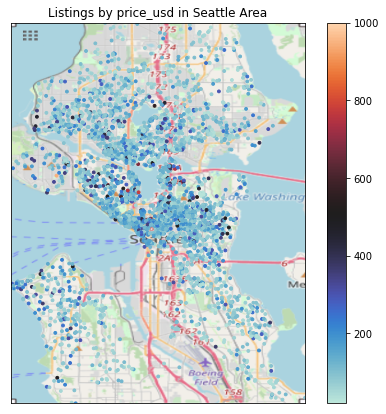

In [176]:
plot_feature_on_map()

This map doesn't show any meaningful relationship between location and price, but that may be because of two key reasons:
- there seem to be a few outliers that skew the color range
- price is measured regardless of listing size and accomodation capacity

Let's go ahead and clean this up.

First, let's normalize prices to show a per guest price:

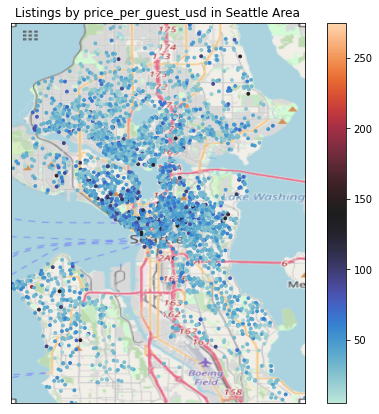

In [177]:
# Get and plot price per guest
q5_df.loc[:, 'price_per_guest_usd'] = q5_df['price_usd'] / q5_df['accommodates']
plot_feature_on_map(df=q5_df, feature='price_per_guest_usd')

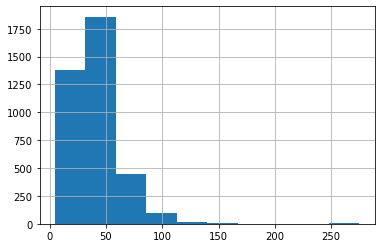

In [178]:
q5_df['price_per_guest_usd'].hist();

In [179]:
# Remove outliers

# price is not normally distributed, and neither is price per guest, so we need to apply log before we remove any rows
q5_df.loc[:,'ppg_log_usd'] = np.log(q5_df['price_per_guest_usd']) # get a normal distribution by applying log

z_scores = stats.zscore(seattle_listings['ppg_log_usd'])
abs_z_scores = np.abs(z_scores)

remove_outliers_mask = (abs_z_scores <= 3) # get mask to remove price with high z scores (above 3)
q5_clean_df = q5_df[remove_outliers_mask]

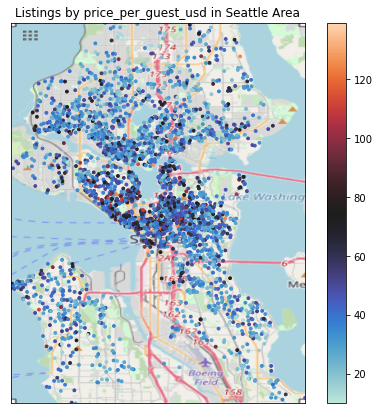

In [180]:
plot_feature_on_map(df=q5_clean_df, feature='price_per_guest_usd', size=8)

Now that prices are normalized and outliers are removed, we can see that there is a concentration of higher prices in the central area.  
This is in the vecinity of the famous [Space Needle](https://goo.gl/maps/jhJ59nS3odwUuTdS8), the [Museum of History and Industry](https://goo.gl/maps/XrtQU93ebdE4T4Mb9) and big parks such as [Volunteer Park](https://goo.gl/maps/7FNVzaHZpywrDpS89) and [Washington Park Botanic Gardens](https://goo.gl/maps/Xu3aHmqF321a5ADp7).  

#### Conclusion:
Q: How much does location impact your listing value?  
A: Location has visible impact on price, with higher prices near the city center, where most attractions are located.